In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter
    <a href=\"https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/\">extensions</a>.
</div>

# SIR parameter learning using nmAPG for exact target

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [0,1]^2} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2,
\end{align}
where $\rho = (\begin{smallmatrix} S & I & R \end{smallmatrix})$ comes from the solution of the traditional forward Susceptibles, Infected, and Recovered (SIR) model, and $\widehat{\rho}$ is a target and known state.
    
For each pair of parameters $\alpha = (\beta, \gamma) \in [0,1]^2$ corresponding to the transmission and the recovery rates, the three variables $S(t)$, $I(t)$, and $R(t)$ are governed by the following differential equations
    
\begin{align}
    \frac{\dif S}{\dif t} &= -\beta S I,
    \\
    \frac{\dif I}{\dif t} &= \beta S I - (\gamma+m) I,
    \\
    \frac{\dif R}{\dif t} &= \gamma I.
\end{align}
    
We note that $S + I + R = n$, where $n$ is the total population. 
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, exp, ones
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals
from scipy.integrate import simpson
from scipy.optimize  import minimize, Bounds
from scipy.interpolate import CubicHermiteSpline
from numpy.polynomial.chebyshev import chebpts1

# Problem setup

In [4]:
# Total population
n = 200
# Initial conditions
f = 5e-3
Sₒ, Iₒ, Rₒ = (1-f)*n, f*n, 0.0
# Rates
α = β, γ = 0.03, 0.6
m = 0

In [5]:
ℛ_ₒ = (β * n)/(γ + m)
print(ℛ_ₒ)

10.0


## Generation of $\widehat \rho$

We are going to generate one choice for $\widehat\rho$ as the three curves that satisfy the initial conditions for a given pair $\alpha=(\beta,\gamma)$.

In [6]:
T  = 10                            # Final time
Tₑ = 0.5*(chebpts1(200)+1) * T     # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])     # Add endpoints

In [7]:
def SIR(t, z, β,γ):
    S, I, R = z
    return [-β*S*I, β*S*I - γ*I - m*I, γ*I]

In [8]:
# Compute state α
ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                  dense_output=True, vectorized=True)
if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
ρ = ρ_sol.y
ρ̂ = ρ.copy()

# Create an abstract interpolator for state
ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)
ρ̄ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)

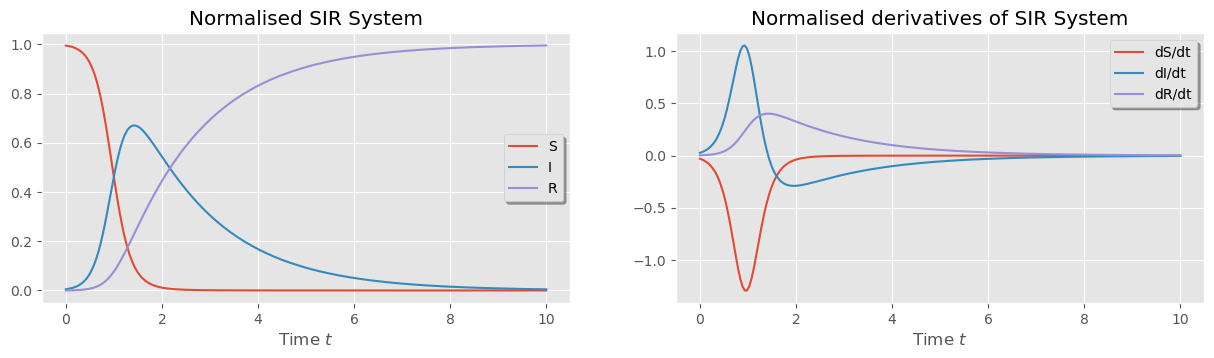

In [9]:
# Plot SIR curves
plt.figure(figsize=(15,3.5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.title('Normalised SIR System')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, asarray(SIR(0.0, ρ, α[0], α[1])).T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dS/dt', 'dI/dt', 'dR/dt'], shadow=True)
plt.title('Normalised derivatives of SIR System')
plt.show()

## Adjoint system

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_S}{\dif t} &= \hat{S} - S +\beta I(q_S - q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I + \beta S(q_S - q_I) + \gamma (q_I - q_R) + m q_I,
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
\end{align}
with the terminal condition $q(T) = 0$.

Let us see how we can implement this with an adaptive step method:

In [10]:
def Adjoint(t, z, β,γ,ρ):
    S̄, Ī, R̄ = ρ̄(t)    # Target
    S, I, R = ρ(t)     # State
    qₛ, qᵢ, qᵣ = z     # Adjoint
    G_q = [S̄ - S + β*I*(qₛ - qᵢ), Ī - I + β*S*(qₛ - qᵢ) + γ*(qᵢ - qᵣ) + m*qᵢ, R̄ - R]
    return asarray(G_q)

Let us try solving this problem for $\rho = \widehat{\rho}$:

In [11]:
solₛ = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(0.1, 0.01,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 50 function evaluations.


We expect the solution to be zero as $\hat{R} = R$ implies $q = 0$.

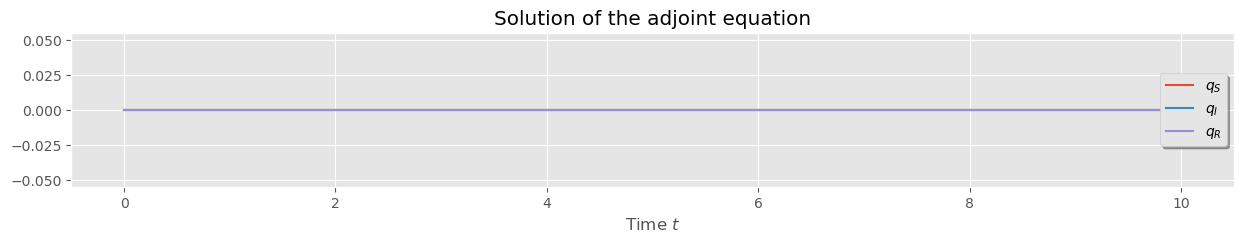

In [12]:
# Plot adjoint curves
plt.figure(figsize=(15,2.))
plt.plot(Tₑ[::-1],solₛ.y.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True, loc = 'center right')
plt.title('Solution of the adjoint equation')
plt.show()

Now we try to optimise the function
\begin{align}
    f(\alpha) = \frac{1}{2} \int\limits_0^T \big( S(t) - \hat{S}(t) \big)^2 + \big( I(t) - \hat{I}(t) \big)^2 + \big( R(t) - \hat{R}(t) \big)^2 \,\dif t.
\end{align}

In [13]:
def Objective(ρ,ρ̂):    return 0.5 * simpson((ρ-ρ̂)**2, x = Tₑ).sum()

In [14]:
def proj(α):    return minimum(maximum(α,0.0),1.0)

In [15]:
print('As an example, the distance between ρ and ρ̂ is {0:.4f}.'.format( Objective(ρ,ρ̂) ))

As an example, the distance between ρ and ρ̂ is 0.0000.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} &= \int\limits_0^T S I( q_I - q_S ) \, \dif t
    \\
    \frac{\partial f}{\partial \gamma} &= \int\limits_0^T I( q_R - q_I ) \, \dif t
\end{align}

In [16]:
q = solₛ.y[:,::-1]

In [17]:
df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), simpson(ρ[1] * (q[2]-q[1]), x=Tₑ)])
display(df.tolist())

[0.0, 0.0]

# Surfaces

We can observe what happens with the cost functional for different values of the hyperparameter $\alpha$:

In [18]:
global ρ, q
ρ = np.zeros_like(ρ̂)
q = np.zeros_like(ρ̂)

In [19]:
def obj_eval_a(α):                # ** Eval just j ** #
    global ρ
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂)
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)

def obj_eval(α):                  # ** Eval j and j' ** #
    global ρ, q
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂)
    f /= (n**2) if scaling else 1.0
    
    # Create an abstract interpolator for state
    #ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)
    # Alternative from ODE struct: 
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(α[0], α[1], ρₜ), t_eval = Tₑ[::-1], dense_output=False, vectorized=False)
    q = q_sol.y[:,::-1]

    # Compute derivative
    df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), simpson(ρ[1] * (q[2]-q[1]), x=Tₑ)])
    df /= (n**2) if scaling else 1.0
    
    return asarray(f), df

In [20]:
# Finer evaluations
nβ, nγ = 51, 51
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.007,1,nβ)
γ_axis = linspace(0.02,1,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a([β,γ]).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [21]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 0.013002638753914707; (β,γ): 0.02686 0.6276


In [22]:
print('Gradient for f(β,γ) = {0}: {1}'.format( *obj_eval([β_axis[i_0[0]],γ_axis[i_0[1]]]) ))

Gradient for f(β,γ) = 0.013002638753914707: [-8.891291    0.01377783]


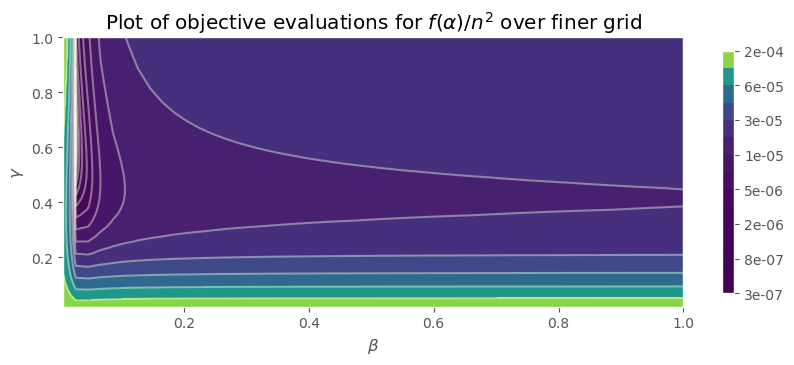

In [23]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 3.5))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
#plt.scatter(β_0, γ_0, s=20, c='#FFFFE6', marker='s')          # Display min
#plt.scatter(ᾱ[0], ᾱ[1], s=20, c='#FFFFE6', marker='x')          # Display min
fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('symlog')
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

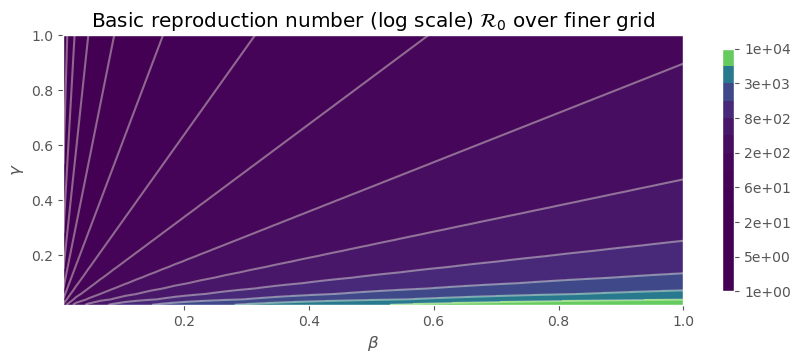

In [24]:
# Contour plot basic reproduction number
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = np.logspace( np.log( Reprod.min() ), np.log( Reprod.max() ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 3.5))
cp = ax.contourf(X_c, Y_c, Reprod, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Basic reproduction number (log scale) $\mathcal{R}_0$ over finer grid')
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

# Solving the optimisation problem

### Misfit with $\widehat{\rho}$

We will use a gradient-based algorithm for optimising $f$. For any $L > 0$, and $\omega \in [0,1]^2$, define the the operator
$$
    p_L (\omega) := \mathcal{P}_{[0,1]^2}[\omega - L^{-1} \nabla f(\omega) ].
$$

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Nonmonotone Accelerated Proximal Gradient Algorithm</h2>
<ol>
<li>Let $\alpha_0 = \alpha_1 = \omega_1 = \nu_1 \in [0,1]^2$, $\theta_0 = 0$, $\theta_1 = 1$, $\mu \in [0,1)$, $\delta >0$, $\eta > 1$, $c_1 = j(\alpha_1)$, $\lambda_1 = 1$.</li>

    
<li>For $k \in \{1,\ldots\}$, do
<ol>
<li>Set 
    \begin{align*}
        \nu_{k} &= \alpha_k + \frac{\theta_{k-1}}{\theta_k} (\omega_k - \alpha_k) + \frac{\theta_{k-1} -1 }{\theta_k} (\alpha_k - \alpha_{k-1}) 
    \\
        s_{k} &= \nu_k - \nu_{k-1}
        \qquad
        r_k = \nabla j(\nu_k) - \nabla j(\nu_{k-1})
    \\
        L_k &= \mathcal{P}_{[10^{-20},10^{20}]} \left( \frac{s_k^\top r_k}{s_k^\top s_k} \right)  
    \end{align*}
    
    
<li>Find the smallest $i_k \in \mathbb{N}$ such that
    \begin{align*}
        L &= \eta^{i_k} L_k
        \\
        \omega_{k+1} &= \mathcal{P} (\nu_k - L^{-1} \nabla j(\nu_k) ) = p_L(\nu_{k})
        \\
    j(\omega_{k+1}) &\leq \max\{c_k,j(\nu_k)\} - \delta \| \omega_{k+1} - \nu_k \|^2
    \end{align*}

    
<li> If $j(\omega_{k+1}) \leq c_k - \delta \| \omega_{k+1} - \nu_k \|^2$, then:
    <ol> 
        <li> $\alpha_{k+1} = \omega_{k+1}$
    </ol>
<li>Else:
    <ol>
        <li> Set 
    \begin{align*}
        s_{k} &= \alpha_k - \nu_{k-1}
        \qquad
        r_k = \nabla j(\alpha_k) - \nabla j(\nu_{k-1})
    \\
        L_k &= \mathcal{P}_{[10^{-20},10^{20}]} \left( \frac{s_k^\top r_k}{s_k^\top s_k} \right)  
    \end{align*}
    <li>Find the smallest $i_k \in \mathbb{N}$ such that
        \begin{align*}
            L &= \eta^{i_k} L_k
            \\
            \xi_{k+1} &= \mathcal{P} (\alpha_k - L^{-1} \nabla j(\alpha_k) ) = p_L(\alpha_{k})
            \\
        j(\xi_{k+1}) &\leq c_k - \delta \| \xi_{k+1} - \alpha_k \|^2
    \end{align*}
        <li> Assign
            \begin{align*}
                \alpha_{k+1} = \begin{cases}
                                    \omega_{k+1} &\text{if }  j(\omega_{k+1}) \leq j(\xi_{k+1}),
                                    \\
                                    \xi_{k+1} &\text{otherwise}.
                               \end{cases}
            \end{align*}
    </ol>
<li> Update $\theta_{k+1} = \frac{1}{2} \Big[ 1 + \sqrt{ 1 + 4 \theta_k^2 } \Big]$
<li> Update $\lambda_{k+1} = \mu \lambda_k + 1$
<li>
<li>

<li>Find the smallest $i_k \in \mathbb{N}$ such that
\begin{align}
    L &= \eta^{i_k} L_k
    \\
    f\big( p_L (\omega_k) \big) &\leq q_L \big( p_L(\omega_k), \omega_k  \big)
\end{align}
    
<li>Update $L_{k+1} = \eta^{i_k} L_k$
<li>Set $\alpha_{k+1} = p_{L_{k+1}} (\omega_k)$
<li>Update $\theta_{k+1} = \frac{5}{11}k + 1$
<li>Update $\omega_{k+1} = \alpha_{k+1} + \frac{\theta_k - 1}{\theta_{k+1}} (\alpha_{k+1} - \alpha_k)$
</li>
</ol>
</div>

Let's select a initial point at random:

In [25]:
β, γ = α = rng(0).uniform(0,1,2)

We will scale $\rho$ and $\widehat{\rho}$ by $n$.

In [26]:
def box_scale(x,y):
    '''
        Return minimum value of scalar s > 0  such that x + sy ∈ [0,1] for x ∈ [0,1]
    '''
    a = np.divide(x, y, where=(y>0))[y>0]
    b = np.divide((x-1), y, where=(y<0))[y<0]
    if len(a) > 0:
        if len(b) > 0:
            return min( a.min(), b.min() )
        else:
            return a.min()
    else:
        return b.min()

In [27]:
def nmAPG(α, iters, save_iter = False, critical = 1, ε = 1e-9, print_tests = False):
    '''
        Create structures to store information from iterates
    '''
    every_iter = {
        'it':[], 'obj':[], 'time':[], 'β':[], 'γ':[], 'df_β':[], 'df_γ':[],
        'norms':{'ℓ_1': [], 'ℓ_2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'time':[], '|df|_2':[], '|df|_max':[]}
    
    '''
        GD iterates
    '''
    print('     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  ')
    print( '{:–^62}'.format('') )
    
    ''' 
        Initialisation
    '''
    # Iterate, interpolation, proximal points
    αₒ = α.copy();    νₒ = α.copy();    ωₒ = α.copy()

    θ = 1.0;    θₒ = 0.0     # Inertia parameter
    μ = 0.60 #0.59    # Degree of nonmonotonicity
    η = 2.4 #2.41     # Scaling for backtracking
    δ = .5e-5         # Sufficient decrease
    I = 10            # Number of iterations for line search
    
    # First objective evaluation
    # Compute state and adjoint for α
    jα, djα = obj_eval(α)
    djνₒ = djα.copy()
    # Initial evaluation
    c = jα;    jαₒ = 0.0
    λ = 1.0
    
    print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(0,
                                                                        jα, 0.0,
                                                                        norm(djα)/(2**0.5), 
                                                                        norm(djα,np.inf) ))
    # Store info for initial point
    if save_iter:
        every_iter['it'].append( 0 )
        every_iter['obj'].append( jα )
        every_iter['time'].append( 0.0 )
        every_iter['β'].append( α[0] )
        every_iter['γ'].append( α[1] )
        every_iter['df_β'].append( djα[0] )
        every_iter['df_γ'].append( djα[1] )
        # Store norms of gradient
        every_iter['norms']['ℓ_2'].append( norm(djα)/(2**0.5) )
        every_iter['norms']['ℓ_1'].append( 0.5 * norm(djα,1) )
        every_iter['norms']['max'].append( norm(djα,np.inf) )
        every_iter['norms']['min'].append( abs(djα).min() )
    
    timed = 0.0
    for k in range(1,iters+1):
        it_time = time.time()
        
        # ------------ Step 1 ------------ #
        # Compute 
        ν = α + (θₒ/θ) * (ωₒ - α) + ((θₒ - 1.0)/θ) * (α - αₒ)
        if print_tests:            print( (1,k), ν) 
        # Project points just in case and evaluate objective and gradient
        ν = proj(ν)
        jν, djν = obj_eval(ν)
        if print_tests:            print( (1,k), jν,djν) 
        # Barzilai–Borwein
        s = ν - νₒ;             r = djν - djνₒ
        L = 1 if k == 1 else s.dot(r)/s.dot(s)
        L = min( max(1e-20, L), 1e20)
        # Go one step ahead: if ν - b * djν goes too far, backtracking will waste time!
        bₜ = box_scale(ν,djν)
        L = max(L, 1.0/bₜ)
        
        # ------------ Step 2 ------------ #
        for i in range(I):
            # Temporary approximation of Lipschitz constant
            Lₓ = η**i * L;        b = 1.0/Lₓ
            # Gradient and proximal step
            ω = proj(ν - b * djν)
            # Evaluate objective at ω
            jω = obj_eval_a(ω)
            # Validate step
            if print_tests:            print( (2,k,i), ω,jω) 
            if (jω + δ * norm(ν - ω)**2) <= max(jν,c):
                break
        # ------------ Step 3 ------------ #
        if (jω + δ * norm(ν - ω)**2) <= c:
            αₒ = α.copy()
            α  = ω.copy()
        else:
            # Barzilai–Borwein
            s = α - νₒ;             r = djα - djνₒ
            L = s.dot(r)/s.dot(s)
            L = min( max(1e-20, L), 1e20)
            #print(s.dot(s), L)
            
            ''' Line search for interpolation '''
            # Go one step ahead: if α - b * djα goes too far, backtracking will waste time!
            # For any component without a zero gradient, the value of b has to satisfy 
            #    b ∈ [(α-1)/djα, α/djα] if djα > 0   and  [α/djα, (α-1)/djα]  if djα < 0
            # Thus the largest b satisfying these conditions is the minimum upper bound of each interval
            #
            bₜ = box_scale(α,djα)
            # Now we can either fix I or change L:
            L = max(L, 1.0/bₜ)
            
            for i in range(I):
                # Temporary approximation of Lipschitz constant
                Lₓ = η**i * L;        b = 1.0/Lₓ
                # Gradient and proximal step
                ξ  = proj(α - b * djα)
                # Evaluate objective at ω
                jξ = obj_eval_a(ξ)
                # Validate step
                if print_tests:            print( (3,k,i), ω,jω) 
                if (jξ + δ * norm(ξ - α)**2) <= c:
                    break
                    
            # Asign next step
            αₒ = α.copy()
            α = ω.copy() if (jω <= jξ) else ξ.copy()
            if print_tests:            print( (2,k), α,jα)
            
        # ------------ Step 4 ------------ #
        # Update objective and previous steps
        jαₒ = jα
        jα, djα = obj_eval(α)
        ωₒ = ω.copy()
        νₒ = ν.copy();        djνₒ = djν.copy()
        
        # Update inertia weights
        θₒ = θ
        θ = 0.5 * (1.0 + (1.0 + 4.0 * θ**2)**0.5)
        if print_tests:            print( (4,k),θ,θₒ)
        # Update exponential convex combination of objectives (19 in Li & Lin 2015)
        c = ((μ * λ * c) + jα)/ ((μ * λ) + 1)
        λ = (μ * λ) + 1
        if print_tests:            print( (4,k),c,λ)
        
        
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time        
        
        if save_iter:
            every_iter['it'].append( k )
            every_iter['obj'].append( jα )
            every_iter['time'].append( timed )
            every_iter['β'].append( α[0] )
            every_iter['γ'].append( α[1] )
            every_iter['df_β'].append( djα[0] )
            every_iter['df_γ'].append( djα[1] )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(djα)/(2**0.5) )
            every_iter['norms']['ℓ_1'].append( 0.5 * norm(djα,1) )
            every_iter['norms']['max'].append( norm(djα,np.inf) )
            every_iter['norms']['min'].append( abs(djα).min() )
        
        if k % critical == 0:
            every_critical['it'].append( k )
            every_critical['obj'].append( jα )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(djα)/(2**0.5) )
            every_critical['|df|_max'].append( norm(djα,np.inf) )
            
            print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(k,
                                                                        jα, timed,
                                                                        norm(djα)/(2**0.5), 
                                                                        norm(djα,np.inf) ))
        
        if abs(jα - jαₒ) < 5e-13 and k > 10:
            print('|j-jₖ| < 5e-13')
            #print(α)
            break
        
        if norm(α - αₒ)/(2.0**0.5) < ε:
            print('‖αₖ - p‖ < {0:1.0e}'.format(ε))
            #print(α)
            break
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    # Due to nonmonoticity, last iterate is not necessarily the best candidate
    idx = np.argmin(every_iter['obj'])
    α = asarray([every_iter['β'][idx], every_iter['γ'][idx]])
    jα = obj_eval_a(α)
    print(α)
    
    return α, ρ, every_critical, every_iter

In [28]:
ᾱ, ρ, every_critical, every_iter = nmAPG(α, 1000, save_iter = True, critical = 10, ε = 1e-7, print_tests = False);

     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  8.0e-01 |     0.00  | 1.821e+00   |   2.575e+00  
*     10 |  5.0e-01 |     0.38  | 1.598e+00   |   2.219e+00  
*     20 |  1.2e-02 |     0.51  | 3.811e+00   |   5.390e+00  
*     30 |  2.7e-03 |     0.62  | 1.274e-01   |   1.365e-01  
*     40 |  2.3e-03 |     0.73  | 2.748e-01   |   3.743e-01  
*     50 |  1.6e-03 |     0.83  | 4.854e-01   |   6.818e-01  
*     60 |  9.8e-04 |     0.93  | 4.944e-01   |   6.967e-01  
*     70 |  5.1e-04 |     1.03  | 4.241e-01   |   5.984e-01  
*     80 |  2.3e-04 |     1.14  | 3.601e-01   |   5.087e-01  
*     90 |  8.1e-05 |     1.24  | 2.966e-01   |   4.193e-01  
*    100 |  2.6e-05 |     1.35  | 2.323e-01   |   3.285e-01  
*    110 |  4.1e-06 |     1.48  | 2.833e-03   |   3.968e-03  
*    120 |  3.5e-06 |     1.68  | 8.220e-03   |   1.100e-02  
*    130 |  3.4e-06 |     1.89  | 6.777e-03   |   8.864e-03  
*    14

---

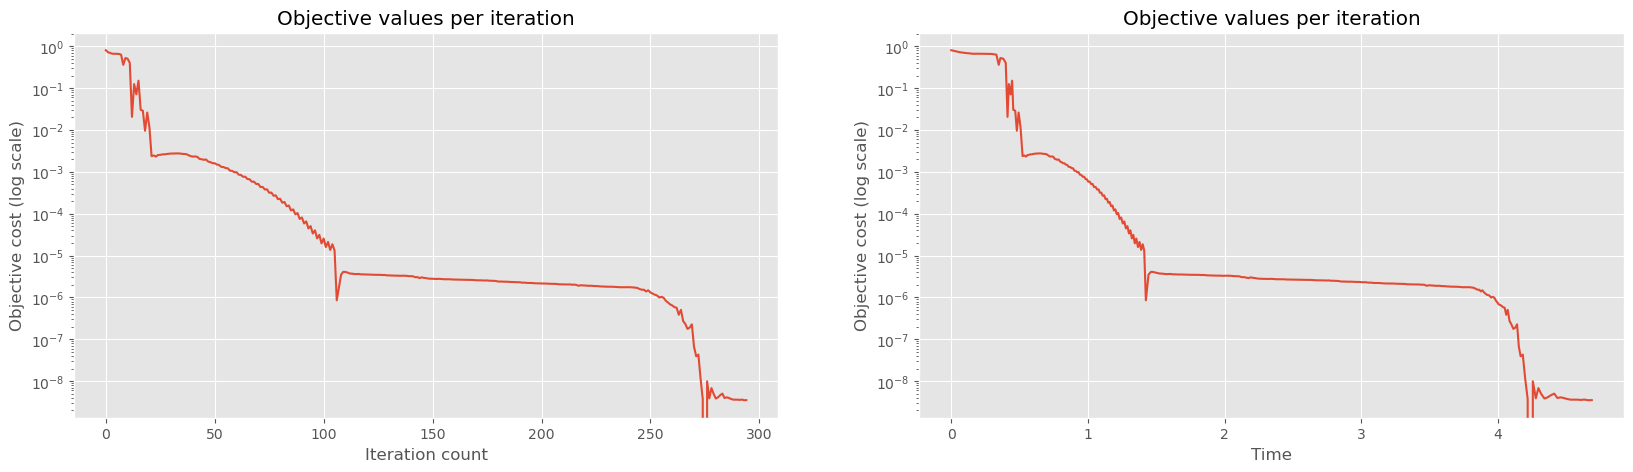

In [29]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['obj'] - min(every_iter['obj']))
plt.yscale('log');    
plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(every_iter['time'],every_iter['obj'] - min(every_iter['obj']))
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [30]:
df_critical = pd.DataFrame.from_dict(every_critical)
#df_critical.to_pickle(out_folder+'Exact_Critical_Exact.pkl') # To read back use pd.read_pickle(file_name)
#df_critical.to_excel(out_folder+'Critical.xlsx')
#display(df_critical)

# If we want this table in LaTeX format run:
#print(df_critical.to_latex(index=False))

In [31]:
#df_every = pd.DataFrame.from_dict(every_iter)
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
display(df_every.tail())
#
df_every.to_pickle('Outputs/Exact – nmAPG - Every.pkl') # To read back use pd.read_pickle(file_name)

,it,obj,time,β,γ,df_β,df_γ,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
290,290,4.980783542507488e-09,4.580678,0.030001,0.599929,0.000606,-0.000137,0.000371,0.000439,0.000606,0.000137
291,291,4.927240900547394e-09,4.608134,0.030000,0.599929,0.000120,-0.000142,0.000131,0.000131,0.000142,0.000120
292,292,5.0008056312502024e-09,4.631730,0.030000,0.599929,-0.000771,-0.000142,0.000457,0.000554,0.000771,0.000142
293,293,4.870036107332972e-09,4.660706,0.030000,0.599930,-0.000299,-0.000135,0.000217,0.000232,0.000299,0.000135
294,294,4.8857724090973656e-09,4.687041,0.030001,0.599930,0.000148,-0.000135,0.000142,0.000142,0.000148,0.000135


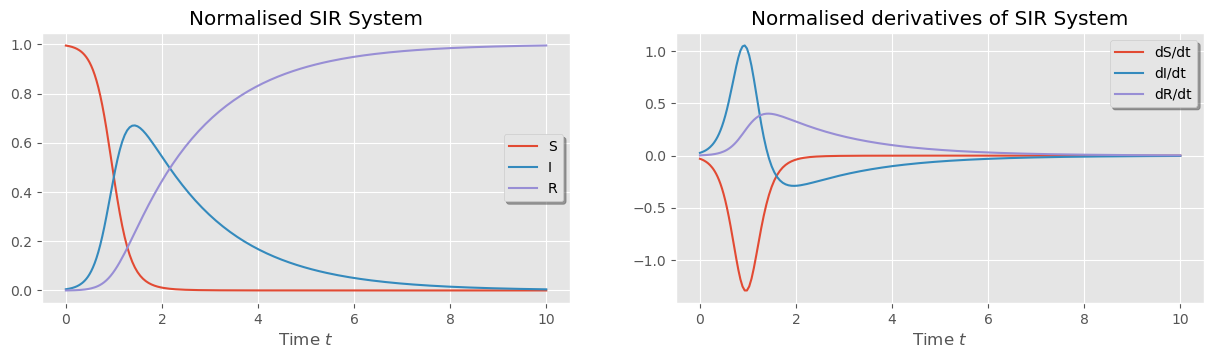

In [32]:
# Plot SIR curves
plt.figure(figsize=(15,3.5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.title('Normalised SIR System')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, asarray(SIR(0.0, ρ, ᾱ[0], ᾱ[1])).T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dS/dt', 'dI/dt', 'dR/dt'], shadow=True)
plt.title('Normalised derivatives of SIR System')
plt.show()

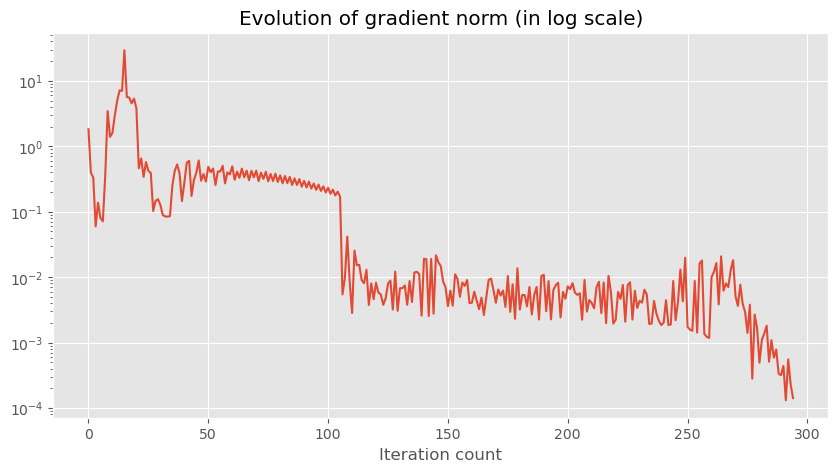

In [33]:
# Evolution of gradient norm
plt.figure(figsize=(10,5))
plt.plot(df_every['norms-ℓ_2'].to_numpy())
#plt.plot(df_every['norms-ℓ_1'].to_numpy())
#plt.plot(df_every['norms-max'].to_numpy())
plt.yscale('log')
#plt.xscale('log')
plt.title('Evolution of gradient norm (in log scale)')
plt.xlabel('Iteration count')
plt.show()

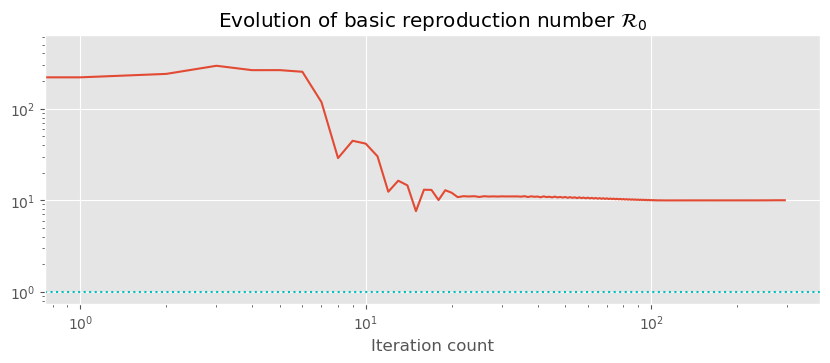

In [34]:
# Evolution of basic reproduction number
plt.figure(figsize=(10,3.5))
plt.plot(df_every['β'].to_numpy() * n / df_every['γ'].to_numpy())
plt.axhline(y=1, c='c', linestyle=':')
plt.yscale('log')
plt.xscale('log')
plt.title('Evolution of basic reproduction number $\mathcal{R}_0$')
plt.xlabel('Iteration count')
plt.show()

In [35]:
α̂ = df_every['β'][ argmin(df_every['obj']) ], df_every['γ'][ argmin(df_every['obj']) ]

β_its, γ_its = df_every['β'].to_numpy(), df_every['γ'].to_numpy()

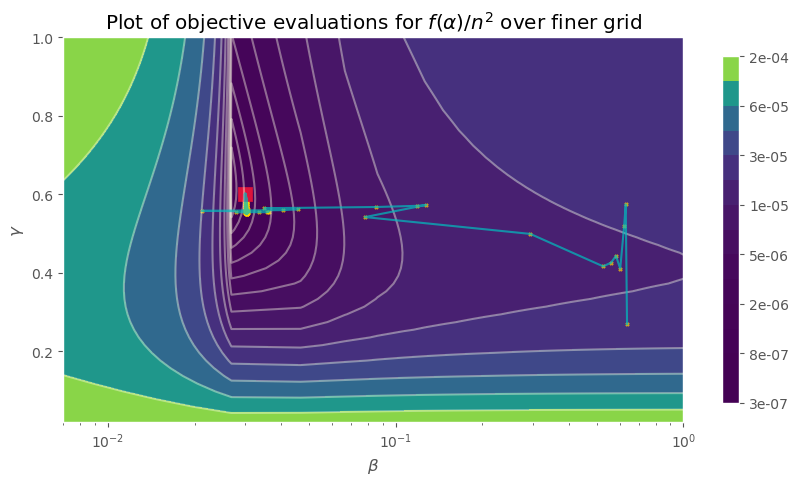

In [36]:
# Contour plot
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

plt.plot( β_its, γ_its, c='c', alpha=0.7, marker='')                          # Optimisation path
plt.scatter( β_its, γ_its, s=5, c='#FFD300', marker='x', alpha=0.7 )
plt.scatter( α̂[0], α̂[1], s=100, marker='s', color='crimson' )                 # Display min

ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
plt.xscale('log')
#plt.xscale('symlog', linthresh = 1e-1)
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

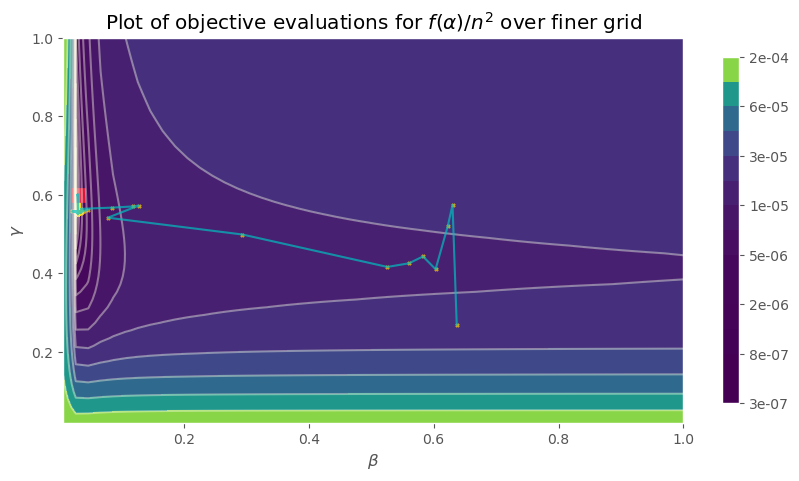

In [37]:
# Contour plot
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

plt.plot( β_its, γ_its, c='c', alpha=0.7, marker='')                          # Optimisation path
plt.scatter( β_its, γ_its, s=5, c='#FFD300', marker='x', alpha=0.7 )
plt.scatter( α̂[0], α̂[1], s=100, marker='s', color='crimson' )                 # Display min

ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 1e-1)
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

---

Visualise convex combination of objectives:

In [38]:
every_iter['it'][-1], asarray(every_iter['obj']).min()

(294, 1.3596066044875185e-09)

In [39]:
Fs = asarray(every_iter['obj'])[1:][::-1]
Ks = np.linspace(every_iter['it'][-1],1,every_iter['it'][-1])

In [40]:
Cs = np.zeros_like(Fs)

In [41]:
for i in range(every_iter['it'][-1]):
    Cs[i] = (0.6**Ks[i:] * Fs[i:][::-1] ).sum()/(0.6**Ks[i:]).sum()

Text(0.5, 0, 'Iteration count')

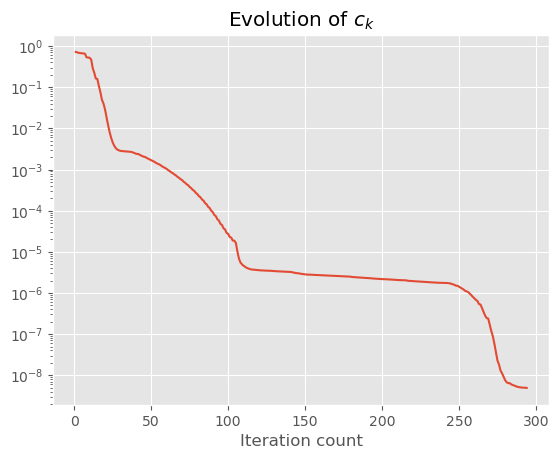

In [42]:
plt.plot(range(1,every_iter['it'][-1]+1), Cs[::-1])
plt.yscale('log')
plt.title('Evolution of $c_k$')
plt.xlabel('Iteration count')

In case Clenshaw–Curtis quadrature is needed:

```Python
# Step 1: Initialize weights array
w = np.zeros(Nₛ + 1)
ii = np.arange(1, Nₛ)
v = np.ones(Nₛ - 1)

# Step 2: Handle weights based on whether N is even or odd
if Nₛ % 2 == 0:
    # For even N
    w[0] = 1 / (Nₛ**2 - 1)
    w[Nₛ] = w[0]
    for kₛ in range(1, Nₛ // 2):
        v -= 2 * np.cos(2 * kₛ * theta[ii]) / (4 * kₛ**2 - 1)
    v -= np.cos(Nₛ * theta[ii]) / (Nₛ**2 - 1)
else:
    # For odd N
    w[0] = 1 / Nₛ**2
    w[Nₛ] = w[0]
    for kₛ in range(1, (Nₛ + 1) // 2):
        v -= 2 * np.cos(2 * kₛ * theta[ii]) / (4 * kₛ**2 - 1)

# Step 3: Finalize the weights for indices 1 to N-1
w[ii] = 2 * v / Nₛ

# Step 4: Project to [0,T]
w *= 0.5 * (Tₑ[-1] - Tₑ[0])
```